# Keras Version

In [1]:
%%bash
python -c 'import keras; print(keras.__version__)'

2.1.2


Using TensorFlow backend.


# Set seed for reproducibility

In [2]:
from numpy.random import seed
seed(777)
# the following 2 lines are only for TF backend
from tensorflow import set_random_seed
set_random_seed(777)

# WideResNet28-10 for fashion mnist (Achieved 95.36%)


- Paper: https://arxiv.org/abs/1605.07146
- Implementation details:
    * No LR decay in the paper
        => LR decay: 1e-04
    * Learning rate drops by 0.2 at 60, 120 and 160 epochs in the paper (total 200 epochs) 
        => Drops learning rate whenever validation loss has plateaued. (factor: 0.2, patience: 10)
    * Data Augmentation: 
        width_shift_range=0.1
        , height_shift_range=0.1
        , horizontal_flip=True
        , shear_range=0.2
        , zoom_range=0.1
    * Channel-wise normalization of the input images: subtracted by mean and divided by std
    * 200 epochs
    * batch_size: 128
- Others: **utils.py** and **base_model.py** are necessary to run this notebook, and dataset should be stored in **'./data/'** beforehand
- For more details of fashion mnist dataset: https://github.com/zalandoresearch/fashion-mnist

In [3]:
def load_mnist(path, kind='train'):
    """ load fashion mnist dataset
    Copied from https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    
    Args:
        path (str): path for dataset
        kind (str): the sort of dataset (train / t10k)
    Returns:
        images (np.ndarray): 2D numpy array of shape (60,000, 784)
        labels (np.ndarray): numpy array of shape (60,000, ) 
    """
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
from keras.callbacks import ReduceLROnPlateau #, LearningRateScheduler
from keras.layers import (Input, Conv2D, BatchNormalization, ZeroPadding2D, Dropout,
                          GlobalAveragePooling2D, Activation, Dense, add)
from keras.models import Model
from keras import optimizers
from keras import regularizers
from base_model import BaseModel

DEPTH = 28
WIDEN_FACTOR = 10
DROPOUT = 0.3

class WideResNet28_10(BaseModel):
    """
    1. ZeroPadding2D (2, 2)
    2. 3X3 Conv2D 16
    3. Wide-basic ResidualBlock X 4
    4. Wide-basic ResidualBlock X 4
    5. Wide-basic ResidualBlock X 4
    6. BN + Relu
    7. GlobalAveragePooling2D
    8. FC 10 + Softmax

    '_build()' is only modified when the model changes.

    HowToUse:
        model = WideResNet28_10()
        * all funtionalities are written in BaseModel.py
    """
    def __init__(self, model_name='WideResNet28_10'):
        """ PAPER: Learning rate drops by 0.2 at 60, 120 and 160 epochs. (total 200 epochs)
        def lr_schedule(epoch):
            initial_lrate = 0.1
            drop_step = 0.2
            drop_rate = 1
            drop_at = [60, 120, 160]

            for e in drop_at:
                if e <= epoch:
                    drop_rate *= drop_step
                else:
                    break

            return initial_lrate * drop_rate
        """
        # HERE: Drops learning rate whenever validation loss has plateaued.
        callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2,
                                       patience = 10, verbose = 1)]
                     #LearningRateScheduler(lr_schedule)]

        # PAPER: 1. no decay in the paper.
        #        2. nesterov is used for experiments in the paper.
        # AUTHOR'S IMPLEMENTATION: nesterov is False.
        # HERE: 1. Learning rate decay: 1e-04
        #       2. nesterov = True
        self.regularizer = regularizers.l2(5e-04)
        optimizer = optimizers.SGD(lr=0.1, momentum=0.9, decay=1e-04, nesterov = True)
        BaseModel.__init__(self, model = self._build(model_name), optimizer = optimizer,
                           callbacks = callbacks)

    def _build(self, model_name):
        """Builds WideResNet-28-10.

        - Identity Mappings in Deep Residual Networks (https://arxiv.org/abs/1603.05027)
          => Full pre-activation
          => https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

        - Wide Residual Networks (https://arxiv.org/abs/1605.07146)
          => No Bottleneck
          => Projection shortcut (B)

        - Author's implementation
          => https://github.com/szagoruyko/wide-residual-networks

        - Global weight decay in keras?
          => https://stackoverflow.com/questions/41260042/global-weight-decay-in-keras

        Returns:
            WideResNet-28-10 model
        """

        n = (DEPTH - 4) // 6 # Depth should be 6n+4
        k = WIDEN_FACTOR
        nStages = [16, 16 * k, 32 * k, 64 * k]

        x = Input(shape = (28, 28, 1))
        y = ZeroPadding2D(padding = (2, 2))(x) # matching the image size of CIFAR-10

        y = Conv2D(nStages[0], (3, 3), padding = 'same',
                   kernel_regularizer = self.regularizer,
                   bias_regularizer = self.regularizer)(y)
        y = self._layer(y, nStages[1], n, (1, 1)) # spatial size: 32 x 32
        y = self._layer(y, nStages[2], n, (2, 2)) # spatial size: 16 x 16
        y = self._layer(y, nStages[3], n, (2, 2)) # spatial size: 8 x 8
        y = BatchNormalization(beta_regularizer = self.regularizer,
                               gamma_regularizer = self.regularizer)(y)
        y = Activation('relu')(y)
        y = GlobalAveragePooling2D()(y)
        y = Dense(units = 10,
                  kernel_regularizer = self.regularizer,
                  bias_regularizer = self.regularizer)(y)
        y = Activation('softmax')(y)

        return Model(x, y, name=model_name)

    def _layer(self, x, output_channel, count, strides):
        """Creates a layer which consists of residual blocks as many as 'count'.

        Returns:
            A layer which consists of multiple residual blocks
        """
        y = self._wide_basic_residual_block(x, output_channel, True, strides)

        for _ in range(1, count):
            y = self._wide_basic_residual_block(y, output_channel, False, (1, 1))

        return y

    def _wide_basic_residual_block(self, x, output_channel, downsampling, strides):
        """Residual Block: x_{l+1} = x_{l} + F(x_{l}, W_{l})

        Returns:
            a single basic-wide residual block
        """
        bottleneck_channel = output_channel

        if downsampling:
            # common BN, ReLU
            x = BatchNormalization(beta_regularizer = self.regularizer,
                                   gamma_regularizer = self.regularizer)(x)
            x = Activation('relu')(x)

            fx = Conv2D(bottleneck_channel, (3, 3), padding = 'same', strides = strides,
                        kernel_regularizer = self.regularizer,
                        bias_regularizer = self.regularizer,
                        kernel_initializer = 'he_normal')(x)
        else:
            # conv3x3
            fx = BatchNormalization(beta_regularizer = self.regularizer,
                                    gamma_regularizer = self.regularizer)(x)
            fx = Activation('relu')(fx)
            fx = Conv2D(bottleneck_channel, (3, 3), padding = 'same',
                        kernel_regularizer = self.regularizer,
                        bias_regularizer = self.regularizer,
                        kernel_initializer = 'he_normal')(fx)

        # conv3x3
        fx = BatchNormalization(beta_regularizer = self.regularizer,
                                gamma_regularizer = self.regularizer)(fx)
        fx = Activation('relu')(fx)
        if DROPOUT > 0:
            fx = Dropout(DROPOUT)(fx)
        fx = Conv2D(bottleneck_channel, (3, 3), padding = 'same',
                    kernel_regularizer = self.regularizer,
                    bias_regularizer = self.regularizer,
                    kernel_initializer = 'he_normal')(fx)

        if downsampling:
            # Projection shorcut
            x = Conv2D(output_channel, (1, 1), padding = 'same', strides = strides,
                       kernel_regularizer = self.regularizer,
                       bias_regularizer = self.regularizer,
                       kernel_initializer = 'he_normal')(x)

        return add([x, fx])

Using TensorFlow backend.


In [5]:
from keras.utils import np_utils
import utils

# Load training set / validation set
X_train, y_train = load_mnist(path='data', kind='train')
X_test, y_test = load_mnist(path='data', kind='t10k')
X_train = utils.normalize_images(X_train)
X_test = utils.normalize_images(X_test)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train = np_utils.to_categorical(y_train) # encode one-hot vector
y_test = np_utils.to_categorical(y_test)

num_of_test_data = 50000
X_val = X_train[num_of_test_data:]
y_val = y_train[num_of_test_data:]
X_train = X_train[:num_of_test_data]
y_train = y_train[:num_of_test_data]

print('training data shape: ', X_train.shape)
print('training labels shape: ', y_train.shape)
print('validation data shape: ', X_val.shape)
print('validation labels shape: ', y_val.shape)

training data shape:  (50000, 28, 28, 1)
training labels shape:  (50000, 10)
validation data shape:  (10000, 28, 28, 1)
validation labels shape:  (10000, 10)


In [6]:
MODEL_NAME = 'WideResNet28_10' # This should be modified when the model name changes.

model = WideResNet28_10()
model.compile()
model.save_model_as_image(MODEL_NAME+'.png')
hist = model.fit_generator((X_train, y_train),
                           (X_val, y_val),
                           epochs=200,
                           batch_size=128)
utils.plot(history=hist, path='training_progress.png', title=MODEL_NAME)

Epoch 1/200
390/390 [==============================] - 389s 998ms/step - loss: 9.4304 - acc: 0.7547 - val_loss: 9.6938 - val_acc: 0.2301
Epoch 2/200
390/390 [==============================] - 381s 977ms/step - loss: 4.6193 - acc: 0.8411 - val_loss: 5.2665 - val_acc: 0.2879
Epoch 3/200
390/390 [==============================] - 380s 975ms/step - loss: 2.4837 - acc: 0.8608 - val_loss: 2.5359 - val_acc: 0.6524
Epoch 4/200
390/390 [==============================] - 380s 975ms/step - loss: 1.4910 - acc: 0.8677 - val_loss: 1.8615 - val_acc: 0.6549
Epoch 5/200
390/390 [==============================] - 380s 975ms/step - loss: 1.0105 - acc: 0.8730 - val_loss: 1.1296 - val_acc: 0.8065
Epoch 6/200
390/390 [==============================] - 380s 975ms/step - loss: 0.7708 - acc: 0.8780 - val_loss: 0.9369 - val_acc: 0.8037
Epoch 7/200
390/390 [==============================] - 380s 974ms/step - loss: 0.6507 - acc: 0.8812 - val_loss: 0.6861 - val_acc: 0.8782
Epoch 8/200
390/390 [====================

390/390 [==============================] - 380s 973ms/step - loss: 0.2656 - acc: 0.9566 - val_loss: 0.3480 - val_acc: 0.9338
Epoch 60/200
390/390 [==============================] - 380s 974ms/step - loss: 0.2682 - acc: 0.9541 - val_loss: 0.3008 - val_acc: 0.9422
Epoch 61/200
390/390 [==============================] - 380s 974ms/step - loss: 0.2690 - acc: 0.9546 - val_loss: 0.3009 - val_acc: 0.9433
Epoch 62/200
390/390 [==============================] - 379s 973ms/step - loss: 0.2690 - acc: 0.9548 - val_loss: 0.3086 - val_acc: 0.9390
Epoch 63/200
390/390 [==============================] - 380s 974ms/step - loss: 0.2660 - acc: 0.9553 - val_loss: 0.3136 - val_acc: 0.9413
Epoch 64/200
390/390 [==============================] - 380s 974ms/step - loss: 0.2638 - acc: 0.9572 - val_loss: 0.3346 - val_acc: 0.9318
Epoch 65/200
390/390 [==============================] - 380s 974ms/step - loss: 0.2634 - acc: 0.9568 - val_loss: 0.3015 - val_acc: 0.9428
Epoch 66/200
389/390 [=========================

390/390 [==============================] - 380s 975ms/step - loss: 0.1782 - acc: 0.9860 - val_loss: 0.2762 - val_acc: 0.9552
Epoch 115/200
390/390 [==============================] - 379s 973ms/step - loss: 0.1804 - acc: 0.9851 - val_loss: 0.2764 - val_acc: 0.9550
Epoch 116/200
389/390 [============================>.] - ETA: 0s - loss: 0.1788 - acc: 0.9848
Epoch 00116: reducing learning rate to 6.399999256245792e-06.
390/390 [==============================] - 380s 975ms/step - loss: 0.1787 - acc: 0.9848 - val_loss: 0.2760 - val_acc: 0.9551
Epoch 117/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1798 - acc: 0.9855 - val_loss: 0.2760 - val_acc: 0.9552
Epoch 118/200
390/390 [==============================] - 380s 974ms/step - loss: 0.1790 - acc: 0.9853 - val_loss: 0.2755 - val_acc: 0.9550
Epoch 119/200
390/390 [==============================] - 380s 975ms/step - loss: 0.1789 - acc: 0.9854 - val_loss: 0.2762 - val_acc: 0.9552
Epoch 120/200
390/390 [===============

Epoch 167/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1776 - acc: 0.9862 - val_loss: 0.2760 - val_acc: 0.9552
Epoch 168/200
390/390 [==============================] - 379s 973ms/step - loss: 0.1801 - acc: 0.9844 - val_loss: 0.2761 - val_acc: 0.9551
Epoch 169/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1791 - acc: 0.9853 - val_loss: 0.2758 - val_acc: 0.9553
Epoch 170/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1790 - acc: 0.9858 - val_loss: 0.2758 - val_acc: 0.9553
Epoch 171/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1799 - acc: 0.9850 - val_loss: 0.2762 - val_acc: 0.9552
Epoch 172/200
390/390 [==============================] - 380s 974ms/step - loss: 0.1785 - acc: 0.9855 - val_loss: 0.2764 - val_acc: 0.9552
Epoch 173/200
390/390 [==============================] - 380s 973ms/step - loss: 0.1797 - acc: 0.9853 - val_loss: 0.2761 - val_acc: 0.9551
Epoch 174/200
390/390 [====

# Test accuracy and Training progress

10000/10000 [==============================] - 20s 2ms/step
[Evaluation on the test dataset]
 [0.29517208900451658, 0.9536] 



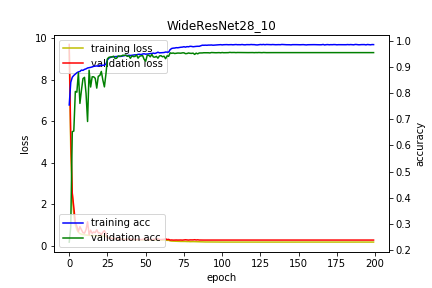

In [8]:
from IPython.display import Image

loss_and_metrics = model.evaluate((X_test, y_test), batch_size = 128)
print('[Evaluation on the test dataset]\n', loss_and_metrics, '\n')
Image("training_progress.png")

# How the model looks like

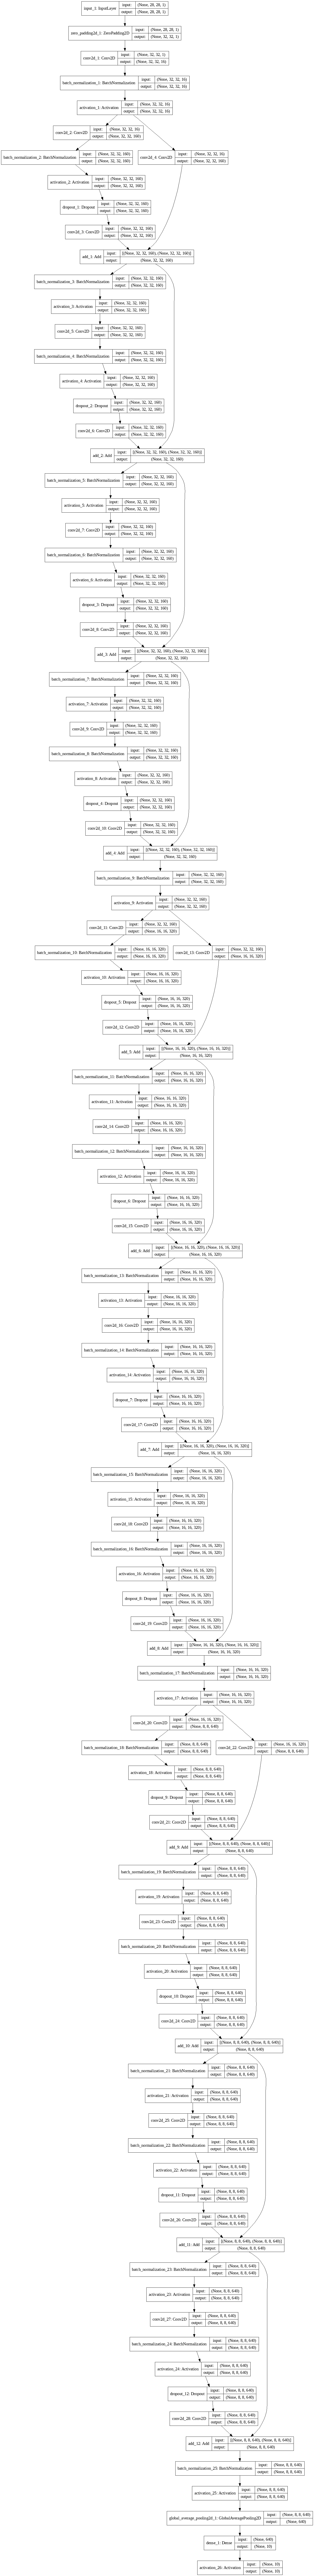

In [9]:
Image(MODEL_NAME+'.png')